日毎の平均気温の予測
<br>
<br>

　1. KerasのLSTMを用いたディープラーニングで、日毎の平均気温を予測するモデルの構築、予測<br>
　2. 予測結果からずれの大きい日を確認し、誤差要因を考察する


1. KerasのLSTMを用いたディープラーニングで、日毎の平均気温を予測するモデルの構築、予測

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import datetime

In [2]:
# 再現性のためランダムシード固定
np.random.seed(seed=0)
tensorflow.random.set_seed(seed=0)

In [3]:
base_dir = "./temporary/"

temperature_csv = "data_temperature.csv"

df_temperature = pd.read_csv(os.path.join(base_dir, temperature_csv), encoding="shift-jis", header=2)


In [4]:
df_temperature.head(10)

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,NaN,NaN,品質情報,均質番号
1,1992/6/18,17.4,8,1
2,1992/6/19,18.1,8,1
3,1992/6/20,17.8,8,1
4,1992/6/21,17.8,4,1
5,1992/6/22,NaN,0,1
6,1992/6/23,NaN,0,1
7,1992/6/24,NaN,0,1
8,1992/6/25,NaN,0,1
9,1992/6/26,20.9,4,1


In [5]:
def df_extract(df):
    return df.iloc[1:, :2]

df_temperature = df_extract(df_temperature)


In [6]:
print(df_temperature.shape)

(10228, 2)


In [7]:
df_temperature.index = pd.to_datetime(df_temperature['年月日'])
df_temperature.drop('年月日', axis=1, inplace=True)

In [8]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10228 entries, 1992-06-18 to 2020-06-18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   平均気温(℃)  10222 non-null  float64
dtypes: float64(1)
memory usage: 159.8 KB


In [9]:
df_temperature = df_temperature.interpolate()

In [10]:
df_temperature

,平均気温(℃)
年月日,
1992-06-18,17.40
1992-06-19,18.10
1992-06-20,17.80
1992-06-21,17.80
1992-06-22,18.42
...,...
2020-06-14,22.50
2020-06-15,26.30
2020-06-16,25.60


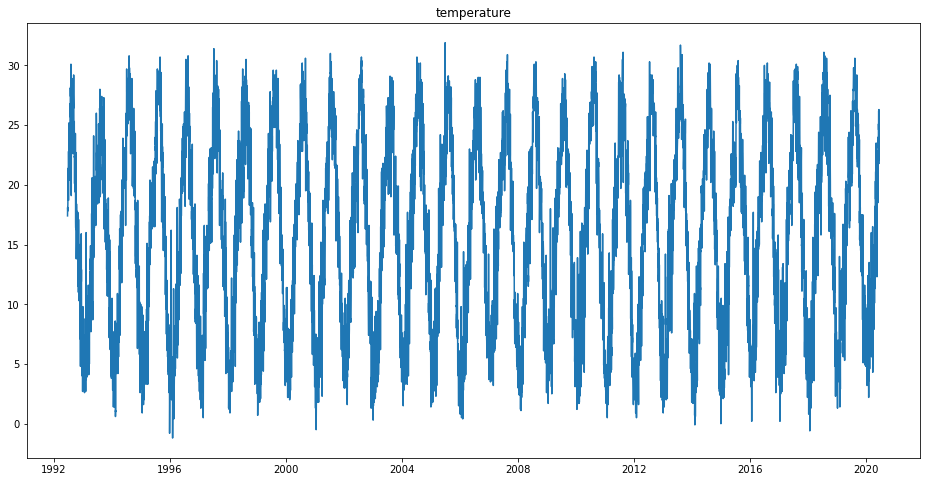

In [11]:
# グラフ化
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df_temperature.index, df_temperature.values[:, 0])
ax.set_title('temperature')
plt.show()

In [12]:
def create_dataset(dataset, look_back):
    data_X, data_y = [], []
    for i in range(look_back, len(dataset)):
        data_X.append(dataset[i-look_back:i, 0])
        data_y.append(dataset[i, 0])
        
    #print(data_X)
    return np.array(data_X), np.array(data_y)

# データセットをtrainとtestに分割
div_idx_test = len(df_temperature) * 2 // 3
train, test = df_temperature.iloc[:div_idx_test, :], df_temperature.iloc[div_idx_test:, :]

# trainデータセットからvalidデータを分割
div_idx_valid = len(train)*3//4
train, valid = train.iloc[:div_idx_valid, :], train.iloc[div_idx_valid:, :]

# データをMinMax
scaler = MinMaxScaler()
scaler_train = scaler.fit(np.reshape(train, (train.shape[0], 1)))
train = scaler_train.transform(np.reshape(train, (train.shape[0], 1)))
valid = scaler_train.transform(np.reshape(valid, (valid.shape[0], 1)))
test = scaler_train.transform(np.reshape(test, (test.shape[0], 1)))

# 終値をdatasetに変換
look_back = 30
train_X, train_y = create_dataset(train, look_back)
valid_X, valid_y = create_dataset(valid, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X = np.reshape(train_X, (train.shape[0]-look_back, look_back, train.shape[1]))
valid_X = np.reshape(valid_X, (valid.shape[0]-look_back, look_back, valid.shape[1]))
test_X = np.reshape(test_X, (test.shape[0]-look_back, look_back, train.shape[1]))

print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(5083, 30, 1) (5083,) (1675, 30, 1) (1675,) (3380, 30, 1) (3380,)


In [13]:
# LSTM
model = Sequential()
model.add(LSTM(80,
               input_shape=(look_back, train.shape[1]),
               recurrent_dropout=0.02))
model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode="min")

model.compile(optimizer='adam', loss='mean_squared_error', lr=1e-3)
model.fit(train_X, train_y,
          epochs=60, 
          batch_size=16, 
          verbose=1, 
          validation_data=[valid_X, valid_y],
          callbacks=[es])


Train on 5083 samples, validate on 1675 samples
Epoch 1/60
5083/5083 [==============================] - 32s 6ms/sample - loss: 0.0099 - val_loss: 0.0063
Epoch 2/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0059 - val_loss: 0.0051
Epoch 3/60
5083/5083 [==============================] - 24s 5ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/60
5083/5083 [==============================] - 25s 5ms/sample - loss: 0.0051 - val_loss: 0.0045
Epoch 5/60
5083/5083 [==============================] - 29s 6ms/sample - loss: 0.0047 - val_loss: 0.0044
Epoch 6/60
5083/5083 [==============================] - 29s 6ms/sample - loss: 0.0043 - val_loss: 0.0038
Epoch 7/60
5083/5083 [==============================] - 25s 5ms/sample - loss: 0.0041 - val_loss: 0.0036
Epoch 8/60
5083/5083 [==============================] - 25s 5ms/sample - loss: 0.0040 - val_loss: 0.0035
Epoch 9/60
5083/5083 [==============================] - 25s 5ms/sample - loss: 0.0041 - val_loss: 0.0035
Epoch 1

In [14]:
# 予測
train_predict = model.predict(train_X)
valid_predict = model.predict(valid_X)
test_predict = model.predict(test_X)

# MInMax逆変換
train_predict = scaler_train.inverse_transform(train_predict)
train_y = scaler_train.inverse_transform([train_y])
valid_predict = scaler_train.inverse_transform(valid_predict)
valid_y = scaler_train.inverse_transform([valid_y])
test_predict = scaler_train.inverse_transform(test_predict)
test_y = scaler_train.inverse_transform([test_y])

# 精度
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print(f"train score: {train_score}")
valid_score = math.sqrt(mean_squared_error(valid_y[0], valid_predict[:, 0]))
print(f"valid_score: {valid_score}")
test_score = math.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print(f"test score: {test_score}")


train score: 2.0936090366910816
valid_score: 2.017469808483037
test score: 2.0742012433498815


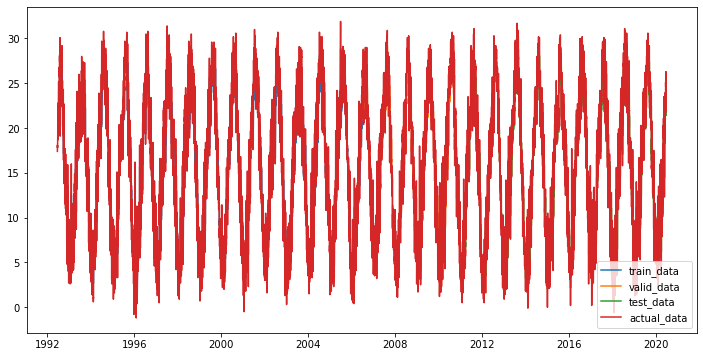

In [15]:
# グラフ化
train_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
train_predict_plot[:, :] = np.nan
idx_train_predict = look_back+len(train_predict)
train_predict_plot[look_back:idx_train_predict, :] = train_predict

valid_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
valid_predict_plot[:, :] = np.nan
idx_valid_predict = look_back+idx_train_predict + len(valid_predict)
valid_predict_plot[look_back+idx_train_predict:idx_valid_predict, :] = valid_predict

test_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, 0], (len(df_temperature), 1)))
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+idx_valid_predict:, :] = test_predict
         
actual_plot = df_temperature.values[:, 0]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(df_temperature.index, train_predict_plot, label='train_data')
ax.plot(df_temperature.index, valid_predict_plot, label='valid_data')
ax.plot(df_temperature.index, test_predict_plot, label='test_data')
ax.plot(df_temperature.index, actual_plot, label='actual_data')

ax.legend(loc='lower right')
plt.show()
fig.savefig('img.png')
   

In [16]:
# 予測値と実際の値の差分
predict_data = np.full(shape=(len(df_temperature), 1), fill_value=-999)
predict_data[look_back:look_back+len(train_predict), :] = train_predict
predict_data[look_back*2+len(train_predict): look_back*2+len(train_predict)+len(valid_predict), :] = valid_predict
predict_data[look_back*3+len(train_predict)+len(valid_predict):, :] = test_predict

diff = df_temperature.values[:, 0] - predict_data[:, 0]
diff[diff>=900] = 0


In [17]:
df_temperature.index

DatetimeIndex(['1992-06-18', '1992-06-19', '1992-06-20', '1992-06-21',
               '1992-06-22', '1992-06-23', '1992-06-24', '1992-06-25',
               '1992-06-26', '1992-06-27',
               ...
               '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12',
               '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16',
               '2020-06-17', '2020-06-18'],
              dtype='datetime64[ns]', name='年月日', length=10228, freq=None)

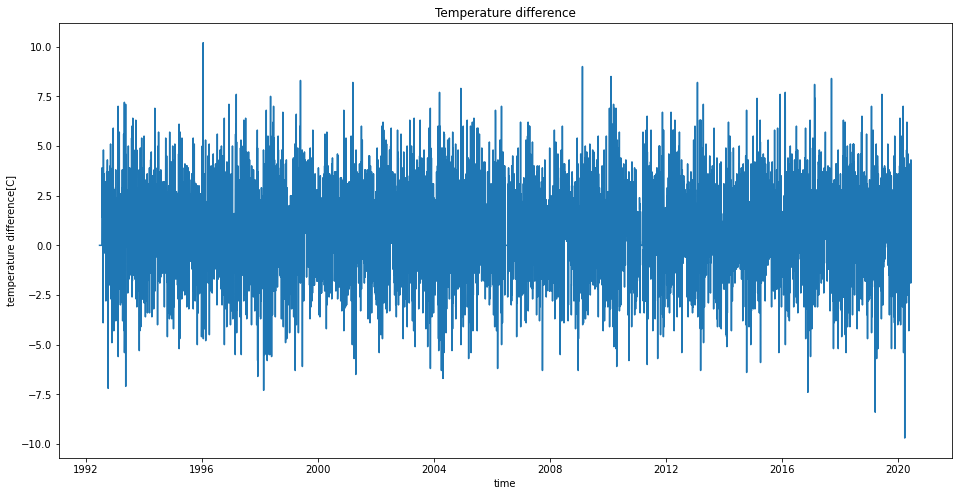

In [18]:
# プロット
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.plot(df_temperature.index, diff)
ax.set_ylabel('temperature difference[C]')
ax.set_xlabel('time')
ax.set_title('Temperature difference')

plt.show()
fig.savefig('diff.png')


In [19]:
# 誤差平均、不偏標準偏差、誤差最大/最小
diff_mean = np.mean(diff)
diff_std = np.std(diff, ddof=1)
diff_max = np.max(abs(diff))
diff_min = np.min(abs(diff))
print(f"mean: {diff_mean}")
print(f"std: {diff_std}")
print(f"max: {diff_max}")
print(f"min: {diff_min}")

mean: 0.8252639812280015
std: 2.05863561011245
max: 10.2
min: 0.0


2. 予測結果からずれの大きい日を確認し、誤差要因を考察する

In [20]:
def create_large_diff(lim_num=7):
    acutual_large_diff = df_temperature.values[np.where(abs(diff)>=lim_num)]
    predict_large_diff = predict_data[np.where(abs(diff)>=lim_num)]
    large_diff_abs = abs(diff[np.where(abs(diff)>=lim_num)])
    day = df_temperature.index.values[np.where(abs(diff)>=lim_num)]
                                           
    df_large_diff = pd.DataFrame({'day': day,
                                  'acutual': acutual_large_diff[:, 0],
                                  'predict': predict_large_diff[:, 0],
                                  'diff_abs': large_diff_abs})

    df_large_diff = df_large_diff.sort_values('diff_abs', ascending=False).reset_index(drop=True)

    season = []
    month = []

    for i in range(len(df_large_diff)):
        tmp_month = df_large_diff.iloc[i, 0].month
        month.append(tmp_month)
        if tmp_month >= 3 and tmp_month <= 5:
            season.append("spring")
        elif tmp_month >= 6 and tmp_month <= 8:
            season.append("summer")
        elif tmp_month >= 9 and tmp_month <= 11:
            season.append('autumn')
        else:
            season.append('winter')
        
    df_large_diff['season'] = season
    df_large_diff['month'] = month
    
    return df_large_diff 

df_large_diff = create_large_diff()


In [21]:
df_large_diff

,day,acutual,predict,diff_abs,season,month
0,1996-01-15,16.2,6,10.2,winter,1
1,2020-03-29,4.3,14,9.7,spring,3
2,2009-02-14,18.0,9,9.0,winter,2
3,2010-02-09,12.5,4,8.5,winter,2
4,2019-03-23,5.6,14,8.4,spring,3
5,2017-09-18,27.4,19,8.4,autumn,9
6,1999-05-25,24.3,16,8.3,spring,5
7,2013-02-02,14.2,6,8.2,winter,2
8,2001-03-15,15.2,7,8.2,spring,3
9,2017-02-17,13.1,5,8.1,winter,2


誤差上位7位中6日が冬に10度以上になる日で占められている。

In [22]:
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 9        1        1        1         1
       10       1        1        1         1
       11       1        1        1         1
spring 3        7        7        7         7
       4        2        2        2         2
       5        5        5        5         5
summer 6        2        2        2         2
winter 1        1        1        1         1
       2       10       10       10        10
       12       3        3        3         3

In [23]:
(len(df_large_diff[df_large_diff['month']==2]) + len(df_large_diff[df_large_diff['month']==3]))/len(df_large_diff)

0.5151515151515151

誤差が7.5度以上だった月のうち、2・3月が52%を占めている。

In [24]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 14
summer: 2
autumn: 3
winter: 14


In [25]:
(len(df_large_diff[df_large_diff['season']=="spring"]) + len(df_large_diff[df_large_diff['season']=="winter"]))/len(df_large_diff)

0.8484848484848485

誤差が7.5度以上だった季節のうち、春と冬が85%を占めている。

In [26]:
df_large_diff = create_large_diff(lim_num=5)
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 9       12       12       12        12
       10      18       18       18        18
       11      17       17       17        17
spring 3       50       50       50        50
       4       48       48       48        48
       5       30       30       30        30
summer 6       18       18       18        18
       7       18       18       18        18
       8        6        6        6         6
winter 1       14       14       14        14
       2       31       31       31        31
       12      22       22       22        22

In [27]:
(len(df_large_diff[df_large_diff['month']==2]) +
 len(df_large_diff[df_large_diff['month']==3]) +
 len(df_large_diff[df_large_diff['month']==4]) +
 len(df_large_diff[df_large_diff['month']==5]))/len(df_large_diff)

0.5598591549295775

誤差が5度以上だった月のうち、2～5月までが56%を占めている。

In [28]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 128
summer: 42
autumn: 47
winter: 67


In [29]:
(len(df_large_diff[df_large_diff['season']=="spring"]))/len(df_large_diff)

0.4507042253521127

誤差が5度以上だった季節のうち、春が45%を占めている。

誤差の大きい日の前後の温度を確認する

In [30]:
def plot_day_front_back(df, day, save_fig_name, len=7):
    t = day-datetime.timedelta(days=len)
    actual_temperature_list = []
    days_list = []
    pred_temperature_list = []
    for i in range(len*2+1):
        actual_temperature_list.append(df.loc[t, df.columns[0]])
        days_list.append(t)
        idx = (t-df.index[0]).days
        t += datetime.timedelta(days=1)    

        if idx < 0 or idx >= df.shape[0]:
            continue
        if idx >= look_back and idx < idx_train_predict:
            pred_temperature_list.append(train_predict_plot[idx, 0])
        elif idx >= look_back+idx_train_predict and idx < idx_valid_predict:
            pred_temperature_list.append(valid_predict_plot[idx, 0])
        elif idx >= look_back+idx_valid_predict:
            pred_temperature_list.append(test_predict_plot[idx, 0])
        
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    ax.plot(days_list, actual_temperature_list, label="actual")
    ax.plot(days_list, pred_temperature_list, label="predict")
    ax.axvline(x=day, color="red")
    ax.legend()
    ax.grid()
    
    ax.set_ylabel("temperature [C]")
    ax.set_xlabel('time')
    plt.show()
    fig.savefig(save_fig_name)


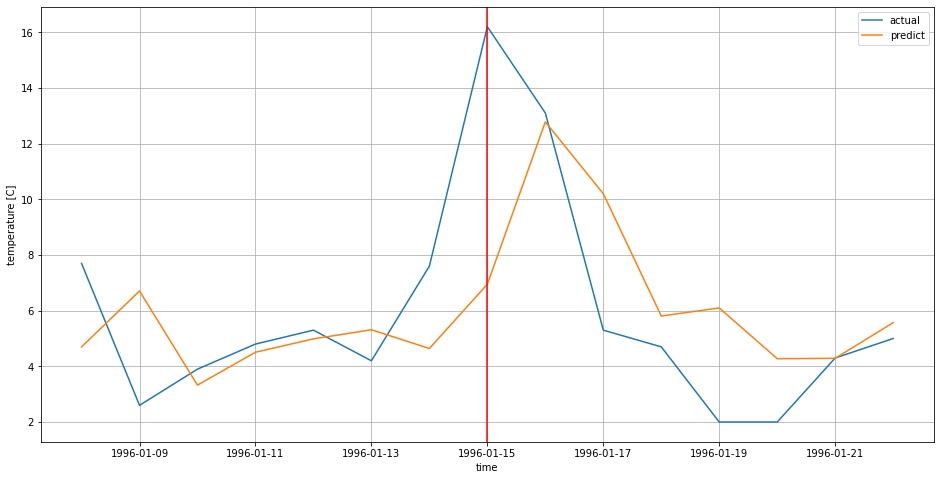

In [31]:
# 誤差1位
plot_day_front_back(df_temperature, df_large_diff.loc[0, 'day'], 'error1.png')


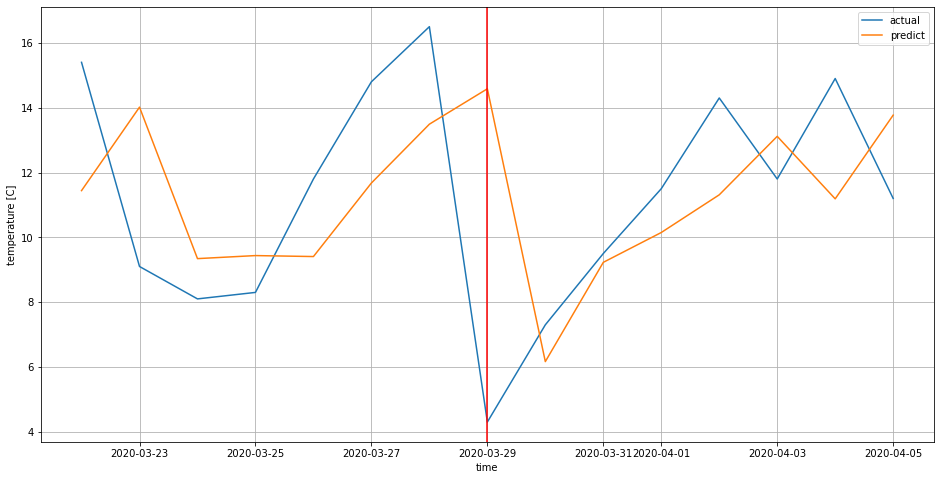

In [32]:
# 誤差2位
plot_day_front_back(df_temperature, df_large_diff.loc[1, 'day'], 'error2.png')

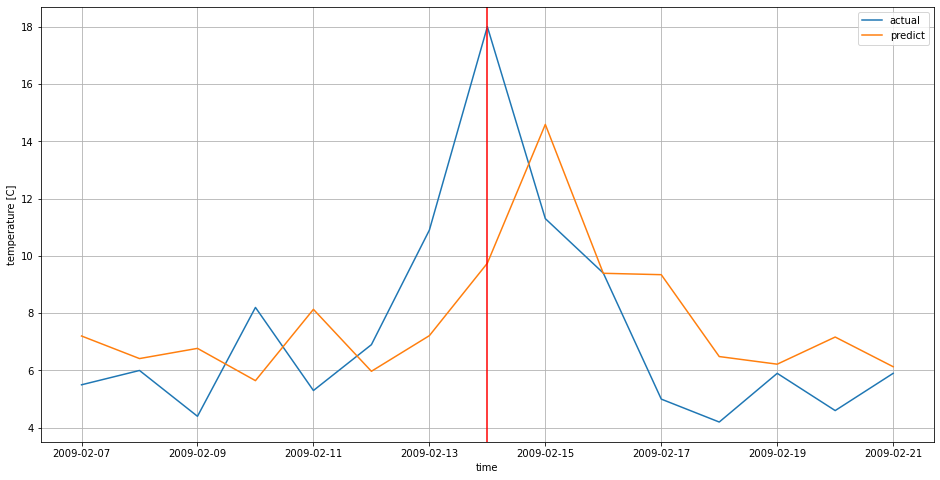

In [33]:
# 誤差3位
plot_day_front_back(df_temperature, df_large_diff.loc[2, 'day'], 'error3.png')

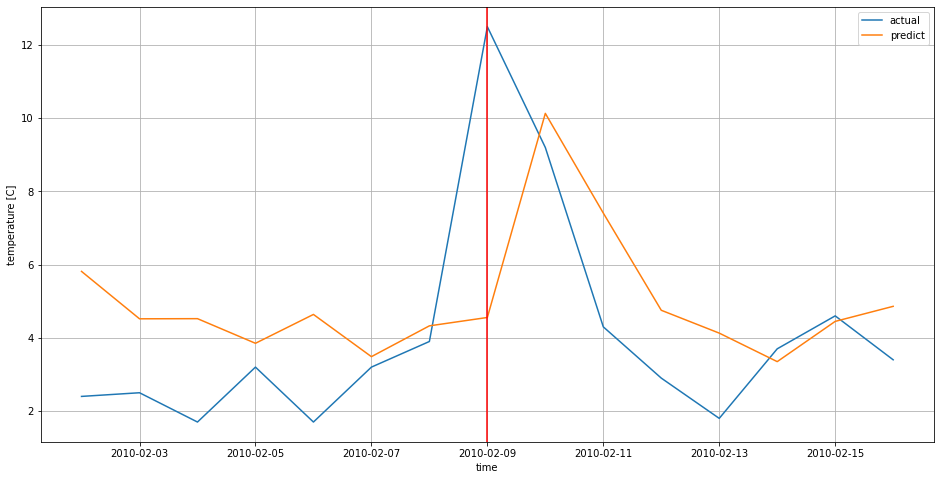

In [34]:
# 誤差4位
plot_day_front_back(df_temperature, df_large_diff.loc[3, 'day'], 'error4.png')

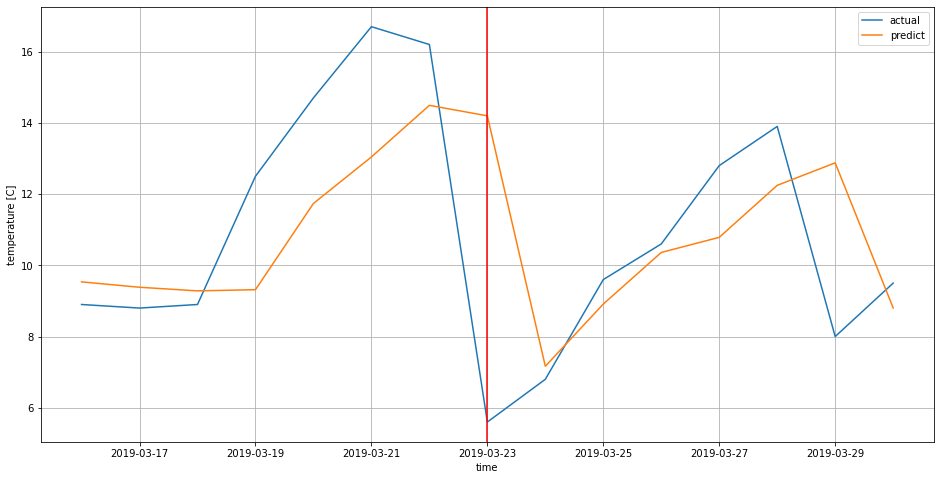

In [35]:
# 誤差5位
plot_day_front_back(df_temperature, df_large_diff.loc[4, 'day'], 'error5.png')

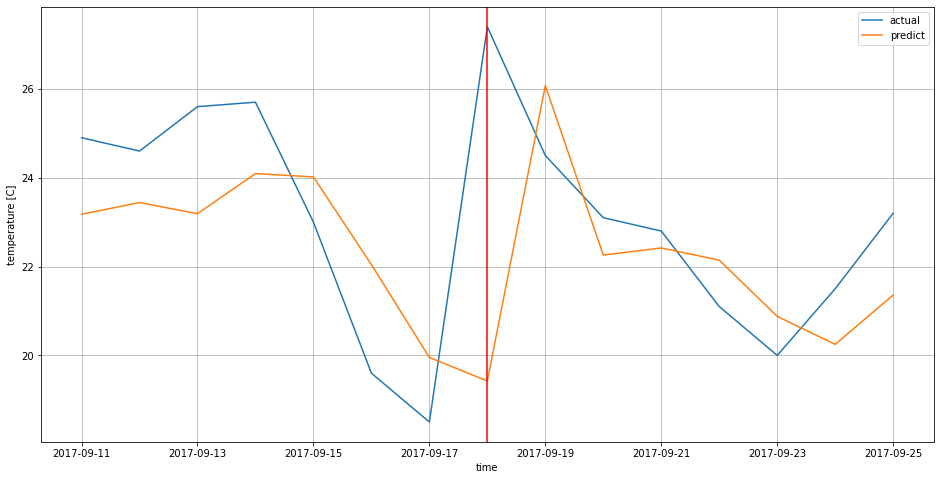

In [36]:
# 誤差6位
plot_day_front_back(df_temperature, df_large_diff.loc[5, 'day'], 'error6.png')

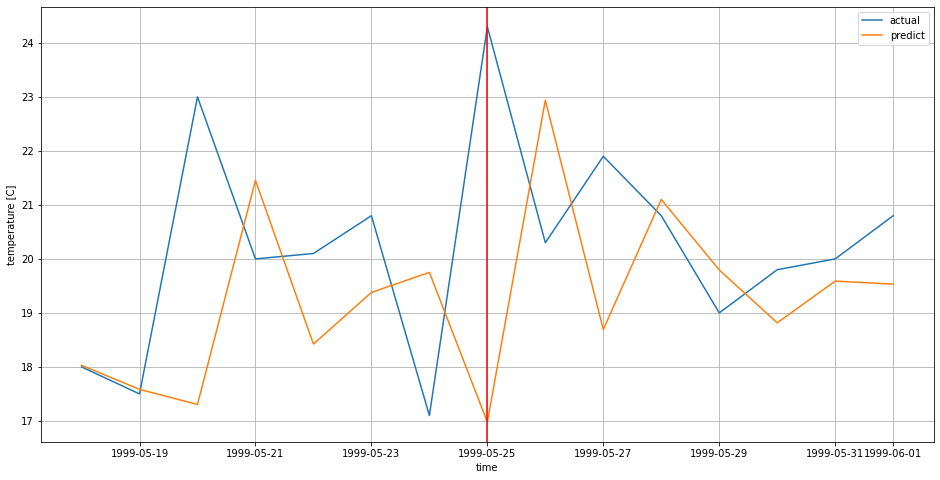

In [37]:
# 誤差7位
plot_day_front_back(df_temperature, df_large_diff.loc[6, 'day'], 'error7.png')

急激な温度変化に追随できていないことがわかる。

誤差要因まとめ

冬の終わりから春にかけての予測が特に外れやすくなっている。<br>
特に、冬に突然暑い日が発生した場合の予測は急激な温度変化に追随できず、10度以上大きく外れている。<br>

